In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Memuat dataset
df = pd.read_csv("CreditCardData.csv")
df.head()

,Transaction ID,Date,Day of Week,Time,Type of Card,Entry Mode,Amount,Type of Transaction,Merchant Group,Country of Transaction,Shipping Address,Country of Residence,Gender,Age,Bank,Fraud
0,#3577 209,14-Oct-20,Wednesday,19,Visa,Tap,£5,POS,Entertainment,United Kingdom,United Kingdom,United Kingdom,M,25.2,RBS,0
1,#3039 221,14-Oct-20,Wednesday,17,MasterCard,PIN,£288,POS,Services,USA,USA,USA,F,49.6,Lloyds,0
2,#2694 780,14-Oct-20,Wednesday,14,Visa,Tap,£5,POS,Restaurant,India,India,India,F,42.2,Barclays,0
3,#2640 960,13-Oct-20,Tuesday,14,Visa,Tap,£28,POS,Entertainment,United Kingdom,India,United Kingdom,F,51.0,Barclays,0
4,#2771 031,13-Oct-20,Tuesday,23,Visa,CVC,£91,Online,Electronics,USA,USA,United Kingdom,M,38.0,Halifax,1


In [3]:
#Jumlah non-Fraud(0) dan fraud(1)
counts = df['Fraud'].value_counts()
print(counts)

Fraud
0    92805
1     7195
Name: count, dtype: int64


In [4]:
df.shape

(100000, 16)

In [5]:
#Menghapus baris yang mengandung nilai NaN(Not a Number) atau nilai kosong dalam data
df.dropna(inplace=True)

In [6]:
df.shape

(99977, 16)

In [7]:
#Jumlah non-Fraud(0) dan fraud(1) -> sesudah di bersihkan datanya
counts = df['Fraud'].value_counts()
print(counts)

Fraud
0    92785
1     7192
Name: count, dtype: int64


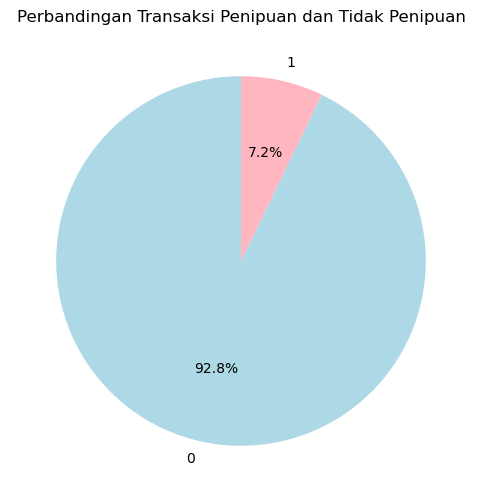

In [8]:
#Visualisasi Jumlah non-fraud(0) dan fraud(1)
fraud_counts = df['Fraud'].value_counts()
labels = ['0', '1']
# Membuat pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    fraud_counts, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['lightblue', 'lightpink']
)
plt.title('Perbandingan Transaksi Penipuan dan Tidak Penipuan')
plt.show()

In [9]:
# Menghapus simbol "£" dari kolom Amount dan mengonversi ke tipe numerik
df['Amount'] = df['Amount'].apply(lambda x: x.replace('£', '')).astype(float)

In [10]:
# Menghapus beberapa kolom yang tidak diperlukan
df = df.drop(['Date','Time','Transaction ID', 'Merchant Group', 'Shipping Address', 'Country of Residence', 'Age'], axis=1)

In [11]:
# Label Encoding untuk kolom kategori
label_encoder = LabelEncoder()
categorical_columns = ['Day of Week', 'Type of Card', 'Entry Mode', 'Type of Transaction', 'Country of Transaction', 'Gender', 'Bank']
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

In [12]:
# Rename columns to match FastAPI format (camelCase)
df.rename(columns={
    'Amount': 'amount',
    'Day of Week': 'dayOfWeek',
    'Type of Card': 'typeOfCard',
    'Entry Mode': 'entryMode',
    'Type of Transaction': 'typeOfTransaction',
    'Country of Transaction': 'countryOfTransaction',
    'Gender': 'gender',
    'Bank': 'bank',
    'Fraud': 'fraud'
}, inplace=True)

In [13]:
# Pisahkan fitur dan target
X = df.drop(columns=['fraud'])  # Fitur
y = df['fraud']  # Target

# Membagi dataset pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [14]:
#PENYEIMBANGAN DATA 9 (Yang di ambil data latih)
# Tampilkan distribusi kelas sebelum SMOTE
print("Distribusi kelas sebelum SMOTE:")
print(y_train.value_counts())

# Menggunakan SMOTE untuk mengatasi ketidakseimbangan kelas
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Tampilkan distribusi kelas setelah SMOTE
print("\nDistribusi kelas setelah SMOTE:")
print(y_train_resampled.value_counts())

Distribusi kelas sebelum SMOTE:
fraud
0    74245
1     5736
Name: count, dtype: int64

Distribusi kelas setelah SMOTE:
fraud
0    74245
1    74245
Name: count, dtype: int64


In [15]:
# Membuat model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# Melatih model dengan data latih yang sudah seimbang dan Memprediksi dengan data uji (Model RF)
rf_model.fit(X_train_resampled, y_train_resampled)

# Menguji Model dan Menampilkan Hasil
y_pred = rf_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     18540
           1       0.24      0.42      0.30      1456

    accuracy                           0.86     19996
   macro avg       0.59      0.66      0.61     19996
weighted avg       0.90      0.86      0.88     19996

